In [7]:
%%writefile src/mmarrays.py

import sys
import numpy as np
#from memory_profiler import profile


def get_data(chunk_size):
    return np.random.rand(chunk_size).astype(np.float64)

#@profile
def write(file_name,chunk_size):

#open a file for data of a single column
    with open(file_name, 'wb') as f:
        #for 1024 "csv files"
        for _ in range(1024):
            csv_data =  get_data(chunk_size)
            f.write(csv_data.tobytes())
    
#@profile
def read(file_name):
    a = np.memmap(file_name, dtype=np.float64)
    return a

if __name__=="__main__":
    CHUNK_SIZE=int(sys.argv[1])
    FILE_NAME = 'data/mmarr.dat'

    write(FILE_NAME,CHUNK_SIZE)
    a = read(FILE_NAME)
    print("Data size = {:.3f} MB".format(a.nbytes*1e-6))
    print("Chunk size = {:.3f} MB".format(CHUNK_SIZE*8*1e-6))

Overwriting src/mmarrays.py


In [160]:
%%bash
strace -tt -T -r -o logs/mmarrays.st python src/mmarrays.py 1000000

Data size = 8192.000 MB
Chunk size = 8.000 MB


In [161]:
!ls -lh logs/m*

-rw-r--r-- 1 vscode vscode 736K Jan 10 14:22 logs/mmarrays.st
-rw-r--r-- 1 vscode vscode 197K Jan 10 13:42 logs/mtmp.csv


In [5]:
#%%writefile src/strace_event_log.py

import csv
import pandas as pd
import pm4py

        
class StraceEventLog:
    def __init__(self,strace_log_path):
        self.st_log = strace_log_path
        self.io_calls = ['read','write','mmap','openat']
        self.total_time = 0.0

    def process_line(self, line):
        ret = line.strip().split()
        time = ret[0]
        dur = ret[-1][1:-1]
        try:
            dur=float(dur)
        except ValueError:
            dur=0.0
        call = ret[3].split('(')[0]
        ret = [call,time,dur]
        #print(ret)
        return ret

    def prepare_csv_log(self,csv_file_path):
        with open(self.st_log,'r') as in_f, open(csv_file_path,'w') as csv_f:
            csv_writer = csv.writer(csv_f)
            csv_writer.writerow(['call','time','duration'])
            for line in in_f:
                ret = self.process_line(line)
                csv_writer.writerow(ret)
        
    def get_io_stats(self,df):
        grouped = df.groupby('call')
        sum_by_call = dict(grouped['duration'].sum())
        stats = []
        for call,dur in sum_by_call.items():
            p = (dur/self.total_time)*100.0
            stats.append([call,dur,p])
        others_dur = self.total_time - df['duration'].sum()
        stats.append(['others',others_dur,(others_dur/self.total_time)*100.0])
        stats.append(['Total',self.total_time,100.0])
        return pd.DataFrame(stats,columns=['call','duration','percent'])


    
    def event_log_from_csv(self,csv_path):
        #self.prepare_df_from_csv(csv_path)
        df = pd.read_csv(csv_path,sep=',')
        self.total_time = df['duration'].sum()
        df = df[df['call'].isin(self.io_calls)]

        stats = self.get_io_stats(df)

        df['case'] = 0
        #print(df)
        df = pm4py.format_dataframe(df,case_id='case',activity_key='call',timestamp_key='time')
        el = pm4py.convert_to_event_log(df)
        return el,stats


In [6]:
st = StraceEventLog("logs/mmarrays.st")
st.prepare_csv_log('logs/mtmp.csv')

In [3]:
!ls -lh logs/m*

-rw-r--r-- 1 vscode vscode 736K Jan 10 14:22 logs/mmarrays.st
-rw-r--r-- 1 vscode vscode 192K Jan 10 15:28 logs/mtmp.csv


In [4]:
el,stats = st.event_log_from_csv('logs/mtmp.csv')
stats

/home/vscode/.local/lib/python3.12/site-packages/pm4py/utils.py:538: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


,call,duration,percent
0,mmap,0.010439,0.221493
1,openat,0.067373,1.429509
2,read,0.014707,0.312051
3,write,4.233352,89.822549
4,others,0.387146,8.214399
5,Total,4.713017,100.000000


In [5]:
dfg,im,fm = pm4py.discover_dfg(el)

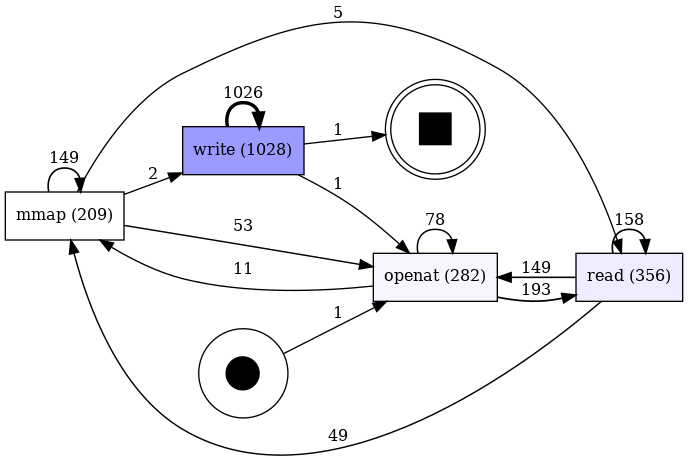

In [6]:
pm4py.view_dfg(dfg,im,fm)

In [159]:
%%bash

strace -tt -T -r python src/mmarrays.py 100000

14:18:40.680087 (+     0.000000) execve("/opt/conda/envs/hdf5-tutorial/bin/python", ["python", "src/mmarrays.py", "100000"], 0x7fff0e238bf8 /* 61 vars */) = 0 <0.000301>
14:18:40.680704 (+     0.000545) brk(NULL) = 0x55c11f054000 <0.000144>
14:18:40.681011 (+     0.000292) readlink("/proc/self/exe", "/opt/conda/envs/hdf5-tutorial/bi"..., 4096) = 44 <0.000099>
14:18:40.681235 (+     0.000218) access("/etc/ld.so.preload", R_OK) = -1 ENOENT (No such file or directory) <0.000070>
14:18:40.681402 (+     0.000169) openat(AT_FDCWD, "/opt/conda/envs/hdf5-tutorial/bin/../lib/tls/haswell/x86_64/libpthread.so.0", O_RDONLY|O_CLOEXEC) = -1 ENOENT (No such file or directory) <0.000063>
14:18:40.681547 (+     0.000145) stat("/opt/conda/envs/hdf5-tutorial/bin/../lib/tls/haswell/x86_64", 0x7ffea8befca0) = -1 ENOENT (No such file or directory) <0.000057>
14:18:40.681679 (+     0.000127) openat(AT_FDCWD, "/opt/conda/envs/hdf5-tutorial/bin/../lib/tls/haswell/libpthread.so.0", O_RDONLY|O_CLOEXEC) = -1 ENOE

Data size = 819.200 MB
Chunk size = 0.800 MB


14:18:44.201504 (+     0.015652) close(5) = 0 <0.000092>
14:18:44.201755 (+     0.000232) munmap(0x7f66a8f7d000, 819200000) = 0 <0.000102>
14:18:44.215624 (+     0.013885) close(3) = 0 <0.000078>
14:18:44.216686 (+     0.001061) munmap(0x7f66da855000, 208896) = 0 <0.000123>
14:18:44.217184 (+     0.000483) munmap(0x7f675ced3000, 16384) = 0 <0.000141>
14:18:44.217940 (+     0.000759) futex(0x7f675c7deb60, FUTEX_WAKE_PRIVATE, 1) = 1 <0.000119>
14:18:44.218183 (+     0.000234) futex(0x7f675c7deb10, FUTEX_WAKE_PRIVATE, 1) = 1 <0.000106>
14:18:44.218389 (+     0.000203) futex(0x7f675c7debe0, FUTEX_WAKE_PRIVATE, 1) = 1 <0.000102>
14:18:44.218635 (+     0.000244) futex(0x7f675c7deb90, FUTEX_WAKE_PRIVATE, 1) = 1 <0.000108>
14:18:44.218859 (+     0.000223) futex(0x7f675c7dec60, FUTEX_WAKE_PRIVATE, 1) = 1 <0.000208>
14:18:44.219174 (+     0.000315) futex(0x7f675c7dec10, FUTEX_WAKE_PRIVATE, 1) = 1 <0.000093>
14:18:44.219385 (+     0.000209) futex(0x7f675c7dece0, FUTEX_WAKE_PRIVATE, 1) = 1 <0.0001

In [188]:
!strace -c python src/mmarrays.py 1000000

Data size = 8192.000 MB
Chunk size = 8.000 MB
% time     seconds  usecs/call     calls    errors syscall
------ ----------- ----------- --------- --------- ------------------
 69.83    2.034369        1978      1028           write
 18.97    0.552585        1959       282        54 openat
  2.79    0.081403         355       229           close
  2.18    0.063631          79       797       112 stat
  1.40    0.040804         114       356           read
  0.95    0.027583         131       209           mmap
  0.89    0.025838          12      2048           madvise
  0.72    0.021015          54       386           fstat
  0.54    0.015679          49       316         3 lseek
  0.52    0.015115         260        58           mprotect
  0.51    0.014838         989        15           clone
  0.28    0.008208          52       157       152 ioctl
  0.13    0.003788          75        50           getdents64
  0.12    0.003524          70        50           brk
  0.08    0.002312   